# Modeling
We test the combination of features from 
- user_info.
- action vector. 
- action_seconds vector. 
- the tf-idf transformation.

Then we apply logistic regression and random forest. We choose logistic regression because feature dimension is high, and it would be relatively easy to separate linearly. We also apply random forest for the feature analysis and comparision. 

# Summary
- We get around 10% increase in accuracy from the logistic regression model. 
- We get around 10% increase in accuracy with the random forest model. 
- We see that age has the highest importance.
- signup_method plays an important role while we didn't see it in the exploratory analysis. We need further analysis for this. 
- We see that activities like 'pending', 'requested' are an important feature for booking analysis. It could be a good starting point to analyze session data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('train_user_session_merged.csv')

In [3]:
df.shape

(65136, 679)

# 1. Data Setup

## Preprocess

In [4]:
from sklearn.preprocessing import LabelEncoder

user_info = ['gender', 'ageCat','signup_method', 'signup_flow',
           'language', 'affiliate_channel', 'affiliate_provider',
           'signup_app', 'first_device_type', 'first_browser','signup_device']

target = 'country_destination'

actions = pd.read_csv('actions.csv', header=None, names=['action']).action.tolist()
actions_sec = [action+'_sec' for action in actions]

actions_summary = ['n_action', 'total_sec', 'avg_sec_per_action']

for col in user_info:
    df[col] = LabelEncoder().fit_transform(df[col])

In [5]:
from sklearn.model_selection import train_test_split

feature_columns = []
feature_columns += user_info
feature_columns += actions

categorical_features=[i for i in range(len(user_info))]
numeric_features = [col for idx, col in enumerate(feature_columns) if idx not in categorical_features]

In [6]:
X = df[feature_columns]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

## Base Accuracy

In [7]:
# original data
y_cnt = df.country_destination.value_counts()
y_cnt_percent = y_cnt/y_cnt.sum()*100
y_cnt_percent

NDF    69.149165
US     30.850835
Name: country_destination, dtype: float64

# 2. Logistic Regression

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

X = df[feature_columns].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

# standarize using train data
std = StandardScaler()
X_train.loc[:,numeric_features] = std.fit_transform(X_train[numeric_features])
X_test.loc[:,numeric_features] = std.transform(X_test[numeric_features])

# dummy variables for categorical variables
ohe = OneHotEncoder(categorical_features=categorical_features)
X_train_ohe = ohe.fit_transform(X_train).toarray()
X_test_ohe = ohe.transform(X_test).toarray()

C:\Users\smkim\Anaconda3\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_ohe, y_train)
y_pred = clf.predict(X_test_ohe)

In [10]:
print('train accuracy: %.2f %%' %(clf.score(X_train_ohe, y_train)*100))
print('test accuracy: %.2f %%' %(clf.score(X_test_ohe, y_test)*100))

train accuracy: 79.48 %
test accuracy: 78.97 %


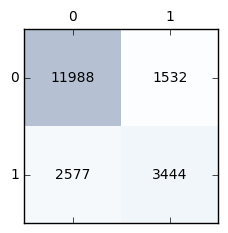

             precision    recall  f1-score   support

        NDF       0.82      0.89      0.85     13520
         US       0.69      0.57      0.63      6021

avg / total       0.78      0.79      0.78     19541



In [11]:
from sklearn.metrics import confusion_matrix, classification_report

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j,y=i,s=mat[i,j], ha='center', va='center')
plt.show()
print(classification_report(y_test, y_pred))

- The performance loss is primarily from failing predicting 'booking'.

# 3. Random Forest

In [12]:
X = df[feature_columns].copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [13]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, max_features=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [14]:
print('train accuracy: %.2f %%' %(clf.score(X_train, y_train)*100))
print('test accuracy: %.2f %%' %(clf.score(X_test, y_test)*100))

train accuracy: 82.07 %
test accuracy: 79.66 %


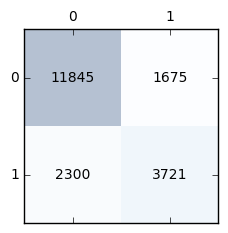

             precision    recall  f1-score   support

        NDF       0.84      0.88      0.86     13520
         US       0.69      0.62      0.65      6021

avg / total       0.79      0.80      0.79     19541



In [15]:
from sklearn.metrics import confusion_matrix, classification_report

mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(2.5,2.5))
ax.matshow(mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(2):
    for j in range(2):
        ax.text(x=j,y=i,s=mat[i,j], ha='center', va='center')
plt.show()
print(classification_report(y_test, y_pred))

In [16]:
importances = clf.feature_importances_
arg_sort = np.argsort(importances)[::-1]
for i in range(10):
    idx = arg_sort[i]
    print('%2d. %-*s %.2f %%' %(i+1,15, feature_columns[idx],importances[idx]*100))

 1. ageCat          24.29 %
 2. pending         13.01 %
 3. missing         8.79 %
 4. requested       5.79 %
 5. signup_method   5.65 %
 6. gender          5.52 %
 7. verify          5.04 %
 8. create          2.04 %
 9. travel_plans_current 1.80 %
10. confirm_email   1.55 %
